In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
sns.set_style("white") # seaborn 有五个主题可以设置 white是其中的一个

%matplotlib inline

# 把任意图像换成uint8格式
def np2u8(image):
    return np.uint8(np.abs(image))

# 简单的预览函数
def c_show(img):
    plt.figure(figsize = (8,8))
    plt.imshow(img,'gray')
    plt.axis = 'off'
    
def m_show(img:list,pics):
    plt.figure(figsize = (12,12))
    for i in range(1,pics+1):
        str = "1"+f"{pics}"+f"{i}"
        plt.subplot(str)
        plt.imshow(img[i-1],'gray')
        # plt.axis = "off"

In [17]:
# 其实两种边缘连接方式没有太大的区别。

def find_one(arr, start,max_len):
    # print(max_len)
    cnt = start
    max_len = len(arr)
    cnt = start
    if(cnt >= max_len):
        return None
    while cnt < max_len and arr[cnt] != 1:
        cnt += 1
    if cnt < max_len and arr[cnt] == 1:
        return cnt
    else:
        return None

# 水平连接边缘像素

def scan_horizon2(g,L = 25):
    (m,n) =  g.shape
    cnt = 0
    for i in range(m):
        line = g[i,:]
        # 初始化 找到第一个front和rear
        # 可以直接通过 np.where(img[i:,]>0)找
        rear = find_one(line,0,n)
        if(rear is not None):
            front = find_one(line,rear+1,n)
            if(front is not None):
                # 第一个front和rear 找到
                if front - rear < L:
                    g[i,rear:front+1] = 1
                while((rear is not None) and (front is not None)):
                    rear = front
                    # print("rear：",rear)
                    front = find_one(line,rear+1,n)
                    if((rear is not None) and (front is not None)):
                        if((front-rear < L)):
                            g[i,rear:front+1] = 1

In [18]:
def scan_horizon(img,L = 25):
    # 第一种连接边缘的方式，检测 1 x 0，0 x 1即变化情况。其实梯度幅值比较大已经代表
    
    edge_flag = np.zeros_like(img)
    rem_ind = np.zeros_like(img) # 记录这一行的索引位置。
    m,n = img.shape
    for i in range(m):
        ind = 0
        for j in range(1,n-1):
            if img[i,j-1] != img[i,j+1]:
                edge_flag[i,j] = 1
                rem_ind[i,ind] = j
                ind += 1
    # 已经生成edge_flag
    for i in range(m):
        # 这样就不需要front和rear多余的手法
        for j in range(1,n):
            front = int(rem_ind[i,j])
            rear = int(rem_ind[i,j-1])
            if(front != 0 and (front-rear < L)):
                img[i,rear:front] = 1      
        

In [19]:
# 对一个函数求梯度的基本操作：
# 1.先模糊
# 2.Sobel x y
# 3.求欧几里得范数和向量角度，注意eps = 1e-10

def get_grad(img):
    gauss = np.array([[1,2,1],[2,4,2],[1,2,1]])/16
    sobel_x = np.array([[-1,-2,-1],[0,0,0],[1,2,1]]) # 是y方向的导数！！！
    sobel_y = sobel_x.T
    eps = 1e-12
    
    img_blur = cv2.filter2D(img,cv2.CV_32F,gauss)
    # 实际上有现成的函数 GuassianBlur和Sobel可以调用，这里注意sobel_x检测的是x方向的边缘，y方向的导数
#     img_blur=cv2.GaussianBlur(img,(3,3),0,0)
#     img_x=cv2.Sobel(img_blur,cv2.CV_64F,1,0,ksize=3)
#     img_y=cv2.Sobel(img_blur,cv2.CV_64F,0,1,ksize=3)
     
    img_y = cv2.filter2D(img_blur,cv2.CV_32F,sobel_x)
    img_x = cv2.filter2D(img_blur,cv2.CV_32F,sobel_y)
    M = (img_x**2+img_y**2)**0.5
    alpha = np.arctan(img_y/(img_x+eps))*180/np.pi
    
    # 转换成0-180度，方便计算。
    m,n = alpha.shape
    alpha = np.where(alpha<0,alpha+180,alpha)
    alpha = np.around(alpha,2)
    return M,alpha

In [20]:
image_path = 'Image/exp3.tif'
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# gray = gray / 255.0  # 先进行一波归一化处理
M,alpha = get_grad(gray)

# 原图像和梯度图像

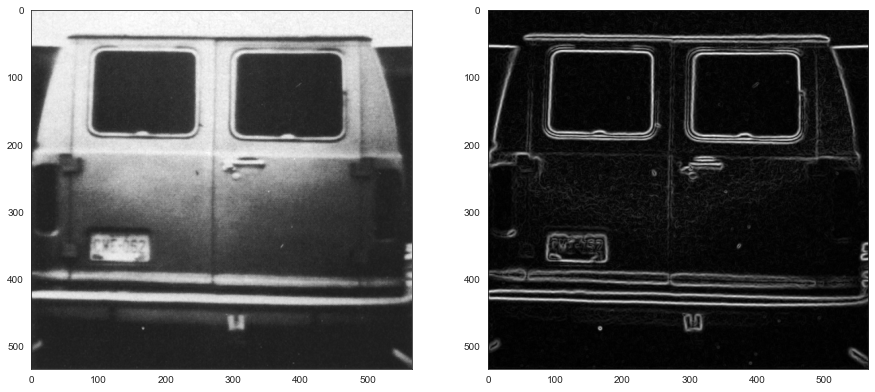

In [21]:
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(img,'gray')
plt.subplot(122)
plt.imshow(M,'gray')

# 二值化图像和边缘连接之后的图像

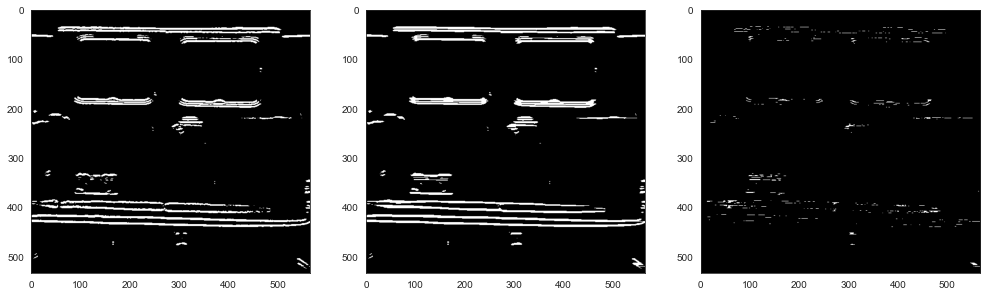

In [13]:
g = np.zeros_like(M) #g与图片大小相同
X, Y = np.where((M > np.max(M) * 0.3)&(alpha>45)&(alpha<135))
g[X, Y] = 1

plt.figure(figsize = (17,17))
plt.subplot(131)
plt.imshow(g,'gray')
g_before = g.copy()
plt.subplot(132)
scan_horizon2(g)
plt.imshow(g,'gray')
g_after = g.copy()
plt.subplot(133)
plt.imshow(g_after-g_before,'gray')
#c_show(g)

In [22]:
MT,alphaT = get_grad(gray.T)
gT = np.zeros_like(MT) #g与图片大小相同
X, Y = np.where((MT > np.max(MT) * 0.3)&(alphaT>45)&(alphaT<135))
gT[X, Y] = 1

# 竖直方向边缘

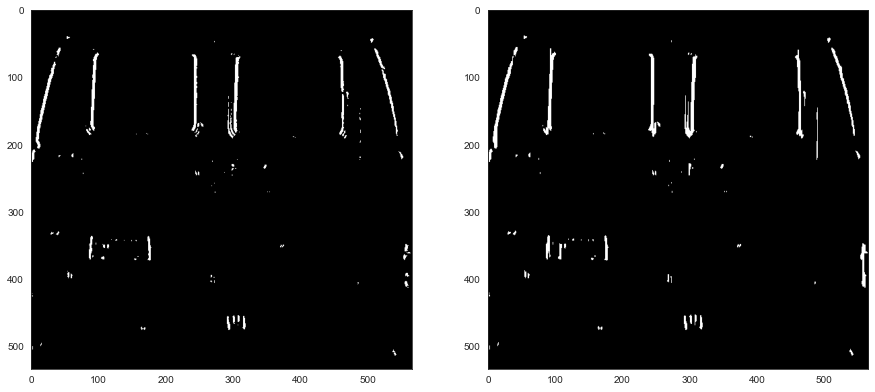

In [23]:
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(gT.T,'gray')
scan_horizon(gT)
plt.subplot(122)
plt.imshow(gT.T,'gray')

# x和y方向合成的结果图

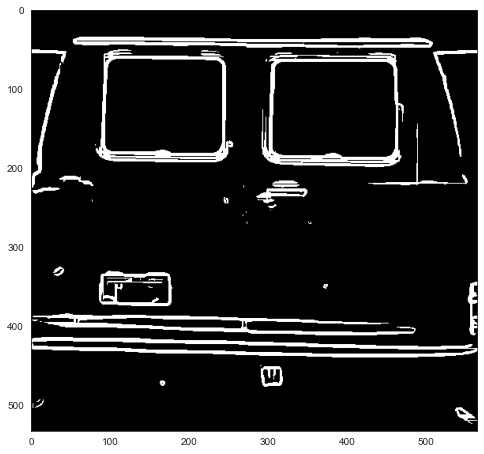

In [10]:
g_final = g+gT.T
g_fin = np.where(g_final >= 1,1,0)
c_show(g_fin)

In [11]:
#行扫描，间隔k时，进行填充，填充值为1
# 充分利用np.where特性 妙呀
def edge_connection(img, size, k):
    for i in range(size):
        Yi = np.where(img[i, :] > 0)
        if len(Yi[0]) >= 10: #可调整
            for j in range(0, len(Yi[0])-1):
                if Yi[0][j+1] - Yi[0][j] <= k:
                    img[i, Yi[0][j]:Yi[0][j+1]] = 1
    return img